In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve

In [34]:
from analysis_routines import *
from ploting_routines import *
from harmonic_analysis import *
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

# Harmoic analysis & Utide

In [17]:
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')

In [18]:
data = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')

### Mareas internas en noviembre, MLD ~ 40 m

In [22]:
# trim time series
dn = 6 # get datapoints every 60 seconds, not every 5
date_1 = datetime(2018, 11, 24)
nov_ci = TidalComponentsFit.compute(df_ci, period=[None, date_1, dn])
nov_c = TidalComponentsFit.compute(df_c, period=[None, date_1, dn])
nov_s = TidalComponentsFit.compute(df_s, period=[None, date_1, dn])

nov_ci.clean()
nov_c.clean()
nov_s.clean()

In [13]:
nov_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,91.461159,132.279859,4.435628,0.755900,4.382713,9.774455
M4,6.210301,4.104317,25.895732,0.939631,0.361909,10.693808,21.986832
M3,8.280401,2.192623,15.214319,0.686782,0.345103,132.240789,28.802418
K1,23.934470,1.192563,8.942766,0.506498,0.331969,329.674770,37.590367


In [18]:
nov_s.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.748111,102.926663,4.578908,0.884614,4.432838,11.080907
M4,6.210301,3.388095,28.218186,0.875159,0.322908,13.128606,21.065475
M3,8.280401,1.550683,11.236634,0.592067,0.346185,132.456683,33.513773
K1,23.934470,1.142053,7.636246,0.508104,0.360387,324.194053,40.664734


In [19]:
nov_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,79.887731,14.892948,0.008225,0.004177,194.033772,29.127263
M6,4.140200,5.503436,8.224472,0.002159,0.001475,105.533699,39.243585
M3,8.280401,5.465824,12.645002,0.002151,0.001186,115.206978,31.665679
3MK7,3.529641,3.745012,4.293285,0.001781,0.001684,270.801365,54.112208
2MK5,4.930880,3.283137,4.035558,0.001667,0.001627,315.761991,55.897757


In [29]:
nov_s.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,85.835195,7.367361,0.008134,0.005873,195.596088,41.411548
M6,4.140200,3.331186,5.399355,0.001602,0.001352,135.499146,48.326857


In [21]:
print('Greenwich phase (degrees) for c+i fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_ci.D1['g']['M2'], 
                                                                                       nov_ci.b2['g']['M2']))

print('Greenwich phase (degrees) for s fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_s.D1['g']['M2'], 
                                                                                       nov_s.b2['g']['M2']))


print('Greenwich phase (degrees) for c fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_c.D1['g']['M2'], 
                                                                                       nov_c.b2['g']['M2']))

Greenwich phase (degrees) for c+i fit: D1 = 4, b2 = 194
Greenwich phase (degrees) for s fit: D1 = 4, b2 = 196
Greenwich phase (degrees) for c fit: D1 = 4, b2 = 196


### Mareas internas principios de diciembre
Mayor amplitud que en noviembre > columna menos estratificada

In [22]:
date_2 = datetime(2018, 11, 30)
date_3 = datetime(2018, 12, 9)
dn = 6 # get datapoints every 60 seconds, not every 5
dec_ci = TidalComponentsFit.compute(df_ci, period=[date_2, date_3, dn])
dec_c = TidalComponentsFit.compute(df_c, period=[date_2, date_3, dn])
dec_s = TidalComponentsFit.compute(df_s, period=[date_2, date_3, dn])

dec_ci.clean()
dec_c.clean()
dec_s.clean()

In [23]:
dec_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.535645,266.030496,6.281629,0.754853,8.013315,6.850779
M4,6.210301,1.261436,6.551205,0.733416,0.561624,42.949152,43.865001
2SK5,4.797373,1.044287,40.018415,0.667310,0.206754,248.650199,17.738680
M3,8.280401,1.040178,7.047954,0.665996,0.491695,303.666911,42.333197


In [24]:
dec_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,65.313225,9.250388,0.009088,0.005856,171.219382,36.740344
M4,6.210301,9.250515,33.270349,0.003420,0.001162,260.135840,19.528351
K1,23.934470,7.325612,5.379877,0.003044,0.002572,216.070450,48.483932
M6,4.140200,6.337007,7.109072,0.002831,0.002081,130.732111,42.125824
2MK5,4.930880,4.160065,11.136096,0.002294,0.001347,196.101088,33.632324
M8,3.105150,3.676344,7.224148,0.002156,0.001572,236.134549,41.783426
2SK5,4.797373,2.368833,6.341266,0.001731,0.001347,298.193647,44.570148


In [25]:
date_4 = datetime(2018, 12, 30, 12)
date_5 = datetime(2019, 1, 14)
dn = 6 # get datapoints every 60 seconds, not every 5
wint_ci = TidalComponentsFit.compute(df_ci, period=[date_4, date_5, dn])
wint_c = TidalComponentsFit.compute(df_c, period=[date_4, date_5, dn])
wint_s = TidalComponentsFit.compute(df_s, period=[date_4, date_5, dn])

In [26]:
wint_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,83.995428,208.252798,8.572150,1.164261,61.241914,7.775781
O1,25.819342,7.849280,7.551337,2.620456,1.869050,227.981525,40.870562
M4,6.210301,2.943525,11.876867,1.604707,0.912643,166.174191,32.599037
K1,23.934470,2.871330,2.759836,1.584906,1.869898,123.936220,67.544022
M8,3.105150,0.605832,11.034244,0.728011,0.429559,222.905126,33.807046
M3,8.280401,0.557106,3.848181,0.698121,0.697524,329.273208,57.225674
2SK5,4.797373,0.432927,9.052105,0.615417,0.400913,355.429821,37.346444
3MK7,3.529641,0.338813,4.536154,0.544430,0.501019,286.936870,52.692034
2MK5,4.930880,0.221673,4.627160,0.440371,0.401252,82.604125,52.147524


In [28]:
wint_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,55.288163,25.736781,0.007923,0.003061,271.252009,22.103982
O1,25.819342,15.554548,15.175736,0.004202,0.002114,161.650295,28.804845
M4,6.210301,12.122555,10.749022,0.003710,0.002218,287.812072,34.239844
K1,23.934470,4.161412,4.070519,0.002174,0.002112,163.401020,55.761139
2MK5,4.930880,3.765107,5.215543,0.002068,0.001774,53.834241,49.155919
M3,8.280401,3.569135,8.913255,0.002013,0.001322,321.217097,37.608709
M8,3.105150,2.128982,7.294621,0.001555,0.001128,293.777665,41.579476
3MK7,3.529641,1.894655,10.727403,0.001467,0.000878,314.558470,34.286726
M6,4.140200,0.906096,1.768867,0.001014,0.001495,154.655956,84.454285


### FFT

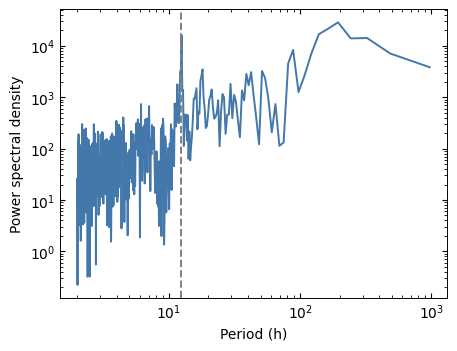

In [16]:
D1 = df_ci[datetime(2018, 11, 16):datetime(2018, 12, 27):120*6]['D1'].to_numpy()
sampling_rate = period_to_freq(1, 'h')
lowcut = period_to_freq(13, 'h')
highcut = period_to_freq(11, 'h')
D1_filtered = bandstop_filter(D1, sampling_rate, lowcut, highcut, order=5)
freqs, ampl, power, psd = spectrum(D1, 1, 1)
plot_spectrum(freqs, psd, 'h', x='period', vlines=[12.405])